In [1]:
import sys
import os

# Aller 2 niveaux au-dessus du notebook
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

# Ajouter à sys.path
sys.path.append(ROOT_DIR)

print("Chemin ajouté :", ROOT_DIR)

Chemin ajouté : d:\CoursLangraph\langGraphe-ai-research-assistant-main


In [ ]:
from langgraph.graph import StateGraph, END, START
from typing import Optional
from pydantic import BaseModel
from src.models.research_models import ResearchQuery, ResearchOutput
from src.models.document_models import ExtractionResult
from src.models.document_models import SummarizationOutput
from src.models.synthesis_models import GlobalSynthesisOutput
from src.agents.researcher_agent import ResearcherAgent
from src.agents.content_extractor_agent import ContentExtractorAgent
from src.agents.summarizer_agent import SummarizerAgent
from src.agents.global_synthesizer_agent import GlobalSynthesizerAgent

In [8]:
# ------------ STATE MODEL ------------

class ResearchState(BaseModel):
    query: Optional[ResearchQuery] = None
    research_output: Optional[ResearchOutput] = None
    extraction_result: Optional[ExtractionResult] = None
    summarization_output: Optional[SummarizationOutput] = None
    global_synthesis_output: Optional[GlobalSynthesisOutput] = None
    attempts: int = 0  # compteur de tentatives


# ------------ AGENTS ------------
researcher_agent = ResearcherAgent()
content_extractor_agent = ContentExtractorAgent()
summarizer_agent = SummarizerAgent()
global_synthesizer_agent = GlobalSynthesizerAgent()


# ------------ GRAPH NODES ------------
async def research_node(state: ResearchState):
    if not researcher_agent.validate_input(state.query):
        raise ValueError("Requête de recherche invalide.")
    out = await researcher_agent.process(state.query)
    # Incrémenter les tentatives
    return {
        "research_output": out,
        "attempts": state.attempts + 1
    }


async def extract_node(state: ResearchState):
    print(state.research_output)
    out = await content_extractor_agent.process_from_research_output(
        state.research_output
    )
    return {"extraction_result": out}


# ------------ FONCTION DE ROUTAGE (pas un nœud) ------------
def should_continue(state: ResearchState) -> str:
    """
    Vérifie si l'extraction a réussi. 
    Si vide et moins de 3 tentatives → relance research_node.
    Sinon → termine.
    """
    if state.extraction_result is None or len(state.extraction_result.documents) == 0:
        if state.attempts < 3:
            print(f"Extraction vide, tentative {state.attempts}, relance du research_node...")
            return "retry"
        else:
            print("Extraction échouée après 3 tentatives, abandon.")
            return "finish"
    print("Extraction réussie !")
    return "finish"

# ---------------- Node de summarisation  ----------------
async def summarize_node(state: ResearchState):
    if state.extraction_result is None or len(state.extraction_result.documents) == 0:
        raise ValueError("Aucun document à résumer.")
    
    output = await summarizer_agent.process_from_extraction_result(state.extraction_result)
    return {"summarization_output": output}

# ---------------- Node de synthèse globale  ----------------
async def global_synthesis_node(state: ResearchState):
    if state.summarization_output is None:
        raise ValueError("Aucun résumé disponible pour la synthèse globale.")
    
    output = await global_synthesizer_agent.process_from_summarization_output(state.summarization_output)
    return {"global_synthesis_output": output}



# ------------ BUILD GRAPH ------------
state_graph = StateGraph(ResearchState)

state_graph.add_node("research_node", research_node)
state_graph.add_node("extract_node", extract_node)
state_graph.add_node("summarize_node", summarize_node)
state_graph.add_node("global_synthesis_node", global_synthesis_node)

# Définition des edges
state_graph.add_edge("research_node", "extract_node")

# Edge conditionnel depuis extract_node
state_graph.add_conditional_edges(
    "extract_node",
    should_continue,  # fonction de routage
    {
        "retry": "research_node",  # retour au début
        "finish": "summarize_node"  # aller au résumé
    }
)
state_graph.add_edge("summarize_node", "global_synthesis_node")

# Point d'entrée et de sortie
state_graph.set_entry_point("research_node")
state_graph.set_finish_point("global_synthesis_node")

# Compilation
app = state_graph.compile()



2025-11-17 22:18:13 | INFO     | agent_researcher | Logger initialisé avec succès.
2025-11-17 22:18:13 | INFO     | agent_researcher | Agent researcher initialisé (ID: d5720e5b-9d54-402c-9a83-26841a91e8e1)
2025-11-17 22:18:13 | INFO     | search_manager | Logger initialisé avec succès.
2025-11-17 22:18:13 | INFO     | tavily_api | Logger initialisé avec succès.
2025-11-17 22:18:13 | INFO     | search_manager | API Tavily initialisée
2025-11-17 22:18:13 | INFO     | serper_api | Logger initialisé avec succès.
2025-11-17 22:18:13 | INFO     | search_manager | API Serper initialisée
2025-11-17 22:18:13 | INFO     | agent_researcher | APIs disponibles: ['tavily', 'serper']
2025-11-17 22:18:13 | INFO     | llm_service | Logger initialisé avec succès.
2025-11-17 22:18:13 | INFO     | agent_researcher | Service LLM initialisé pour l'extraction de mots-clés
2025-11-17 22:18:13 | INFO     | agent_content_extractor | Logger initialisé avec succès.
2025-11-17 22:18:13 | INFO     | agent_content_e

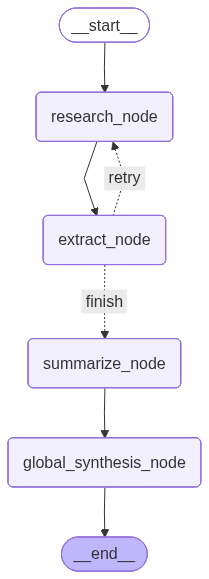

In [9]:
from IPython.display import Image 
display(Image(app.get_graph().draw_mermaid_png()))

In [10]:
topic = "impact de l'intelligence artificielle sur le marché de l'emploi"

######################################################################
#Implémenter aussi l'extraction en fonction de l'extension du fichier et le js



# Extraction automatique des mots-clés
keywords = await researcher_agent.extract_keywords_with_llm(topic)
print(f"Mots-clés extraits automatiquement: {keywords}")

state = ResearchState(
    query=ResearchQuery(
        topic=topic,
        keywords=keywords,
        max_results=2,
        search_depth="basic"
    )
)

# Utilisation propre dans un notebook
result = await app.ainvoke(state)


2025-11-17 22:18:20 | INFO     | agent_researcher | Extraction de mots-clés pour: 'impact de l'intelligence artificielle sur le marché de l'emploi'
2025-11-17 22:18:24 | INFO     | agent_researcher | Mots-clés extraits: ['intelligence artificielle', 'machine learning', 'automatisation', 'emploi', 'marché du travail', 'robotisation', "perte d'emploi"]
Mots-clés extraits automatiquement: ['intelligence artificielle', 'machine learning', 'automatisation', 'emploi', 'marché du travail', 'robotisation', "perte d'emploi"]
2025-11-17 22:18:24 | INFO     | agent_researcher | Début de recherche pour: 'impact de l'intelligence artificielle sur le marché de l'emploi'
2025-11-17 22:18:24 | INFO     | agent_researcher | Requête préparée: 'impact de l'intelligence artificielle sur le marché de l'emploi machine learning automatisation marché du travail robotisation perte d'emploi'
2025-11-17 22:18:24 | INFO     | search_manager | Tentative de recherche avec tavily
2025-11-17 22:18:24 | INFO     | tav

In [11]:
result


{'query': ResearchQuery(topic="impact de l'intelligence artificielle sur le marché de l'emploi", keywords=['intelligence artificielle', 'machine learning', 'automatisation', 'emploi', 'marché du travail', 'robotisation', "perte d'emploi"], max_results=2, search_depth='basic', date_range=None),
 'research_output': ResearchOutput(query=ResearchQuery(topic="impact de l'intelligence artificielle sur le marché de l'emploi", keywords=['intelligence artificielle', 'machine learning', 'automatisation', 'emploi', 'marché du travail', 'robotisation', "perte d'emploi"], max_results=2, search_depth='basic', date_range=None), results=[SearchResult(title="Quel est l'impact de l'IA sur le marché du travail en 2025 ? - DataBird", url=HttpUrl('https://www.data-bird.co/blog/impact-ia-marche-du-travail-2025'), snippet='Découvrez comment l’intelligence artificielle transforme le marché du travail et les métiers de la Data en 2025. Découvrez comment l’intelligence artificielle transforme le marché du trava

In [25]:
import httpx

url = "https://nextmux.net/company/blog-news/63-limpact-de-lia-sur-le-marche-de-lemploi-une-revolution-en-cours"

resp = httpx.get(url, headers={"User-Agent": "Mozilla/5.0"})
print(resp.status_code)
print(resp.text[:500])


C:\Users\sirou\AppData\Roaming\Python\Python312\site-packages\debugpy\_vendored\pydevd\_pydevd_bundle\pydevd_trace_dispatch_regular.py:326: RuntimeWarning: coroutine 'main' was never awaited
  def __call__(self, frame, event, arg):


200
<!DOCTYPE html><html lang="en"><head><meta charSet="utf-8"/><meta name="viewport" content="width=device-width"/><meta name="next-head-count" content="2"/><link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/swiper@8/swiper-bundle.min.css"/><meta name="theme-color" content="#052425"/><meta name="description" content="Optimisez la gestion de votre entreprise avec nos solutions numériques complètes. Nous offrons des infrastructures et matériels informatiques haut de gamme, ainsi que l&#x27;enr


# Interaction avec un llm

In [25]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, END
from typing import TypedDict, Sequence, Annotated, Union
from langchain_core.messages import BaseMessage
from dotenv import load_dotenv
from langchain_core.tools import tool
import os
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
import asyncio

# ============================================================================
# VOS AGENTS EXISTANTS (ne pas modifier)
# ============================================================================
researcher_agent = ResearcherAgent()
content_extractor_agent = ContentExtractorAgent()
summarizer_agent = SummarizerAgent()
global_synthesizer_agent = GlobalSynthesizerAgent()

# ============================================================================
# OUTIL QUI ENCAPSULE VOTRE PIPELINE COMPLET
# ============================================================================
@tool
def research_complete_pipeline(topic: str, max_results: Union[int, str] = 2) -> str:
    """Exécute un pipeline de recherche complet sur un sujet donné.
    
    Ce tool encapsule 4 agents qui travaillent ensemble :
    1. ResearcherAgent : recherche web et extraction de mots-clés
    2. ContentExtractorAgent : extraction du contenu des pages
    3. SummarizerAgent : création de résumés détaillés
    4. GlobalSynthesizerAgent : synthèse globale finale
    
    Args:
        topic: Le sujet de recherche (ex: "impact de l'IA sur l'emploi")
        max_results: Nombre de sources à analyser (2-10, défaut: 2)
    
    Returns:
        Un rapport complet au format texte avec résumé exécutif et analyse détaillée
    """
    # Conversion et validation
    if isinstance(max_results, str):
        try:
            max_results = int(max_results)
        except ValueError:
            max_results = 2
    max_results = max(2, min(max_results, 10))
    
    async def run_pipeline():
        print(f"\n{'='*60}")
        print(f"🚀 DÉMARRAGE DU PIPELINE DE RECHERCHE")
        print(f"📋 Sujet: {topic}")
        print(f"📊 Sources à analyser: {max_results}")
        print(f"{'='*60}\n")
        
        # ÉTAPE 1: Recherche
        print("🔍 [1/4] Recherche web en cours...")
        query = ResearchQuery(
            topic=topic,
            keywords=await researcher_agent.extract_keywords_with_llm(topic),
            max_results=max_results,
            search_depth="basic"
        )
        research_data = await researcher_agent.process(query)
        print(f"✅ Trouvé {research_data.total_found} sources")
        
        # ÉTAPE 2: Extraction
        print("\n📄 [2/4] Extraction du contenu...")
        extraction_data = await content_extractor_agent.process_from_research_output(
            research_output=research_data
        )
        print(f"✅ Extrait {extraction_data.successful_extractions} documents")
        
        # ÉTAPE 3: Résumés
        print("\n📝 [3/4] Création des résumés...")
        summarization_data = await summarizer_agent.process_from_extraction_result(
            extraction_result=extraction_data
        )
        print(f"✅ Généré {summarization_data.total_documents} résumés")
        
        # ÉTAPE 4: Synthèse globale
        print("\n🎯 [4/4] Synthèse globale...")
        global_synthesis = await global_synthesizer_agent.process_from_summarization_output(
            summarization_output=summarization_data
        )
        print(f"✅ Rapport final généré ({global_synthesis.final_report.word_count} mots)")
        
        print(f"\n{'='*60}")
        print("✨ PIPELINE TERMINÉ AVEC SUCCÈS")
        print(f"{'='*60}\n")
        
        # Retourner le rapport en format markdown
        return global_synthesis.formatted_outputs.get('markdown', 
                                                        global_synthesis.formatted_outputs.get('text', 
                                                        str(global_synthesis))
                                                        )
    
    return asyncio.run(run_pipeline())

# ============================================================================
# CONFIGURATION DU LLM ET DU GRAPHE
# ============================================================================

# État du graphe
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Chargement des variables d'environnement
load_dotenv()
api_key = os.getenv("GROQ_API_KEY")
if not api_key:
    raise ValueError("GROQ_API_KEY non définie dans .env")

# Configuration du modèle avec l'outil
tools = [research_complete_pipeline]
model = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.3,  # Bas pour plus de cohérence
    max_tokens=2048*2,
    api_key=api_key
).bind_tools(tools)

# ============================================================================
# NŒUDS DU GRAPHE
# ============================================================================

def model_call(state: AgentState) -> AgentState:
    """Nœud qui appelle le LLM pour décider quoi faire"""
    
    system_prompt = SystemMessage(content="""Tu es un assistant de recherche intelligent.

        🎯 TON RÔLE:
        Tu aides les utilisateurs à obtenir des résumés et analyses sur n'importe quel sujet.

        🔧 TON OUTIL:
        Tu as accès à un outil puissant appelé 'research_complete_pipeline' qui :
        - Effectue des recherches web automatiques
        - Extrait et analyse le contenu
        - Génère des résumés détaillés
        - Produit une synthèse globale complète

        📋 QUAND L'UTILISER:
        Utilise cet outil quand l'utilisateur demande :
        - Un résumé sur un sujet
        - Des informations sur un topic
        - Une analyse d'un domaine
        - Une recherche documentée

        💡 COMMENT L'UTILISER:
        - Identifie le sujet principal de la demande
        - Appelle research_complete_pipeline avec le sujet en français clair
        - Utilise max_results=2 pour une recherche standard

        ✅ EXEMPLES:
        User: "Résume l'impact de l'IA sur l'emploi"
        → Appelle: research_complete_pipeline(topic="impact de l'intelligence artificielle sur le marché de l'emploi", max_results=2)
        User: "Fais-moi une analyse complète sur le changement climatique"
        → Appelle: research_complete_pipeline(topic="changement climatique", max_results=3)

        ⚠️ IMPORTANT:
        - N'essaie PAS de faire la recherche toi-même
        - Utilise TOUJOURS l'outil pour les demandes de recherche
        - Le résultat de l'outil est déjà un rapport complet formaté
        - Tu peux présenter le résultat directement à l'utilisateur
    """
                                  
            )
    
    messages = state["messages"]
    response = model.invoke([system_prompt] + messages)
    return {"messages": [response]}

def should_continue(state: AgentState) -> str:
    """Décide si on continue avec des outils ou si on termine"""
    messages = state["messages"]
    last_message = messages[-1]
    
    # Si le dernier message a des appels d'outils, continuer
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "continue"
    else:
        return "end"

# ============================================================================
# CONSTRUCTION DU GRAPHE LANGGRAPH
# ============================================================================

# Créer le graphe
graph = StateGraph(AgentState)

# Ajouter les nœuds
graph.add_node("llm", model_call)
tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

# Définir le point d'entrée
graph.set_entry_point("llm")

# Ajouter les transitions conditionnelles
graph.add_conditional_edges(
    "llm",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)

# Après l'exécution des outils, retourner au LLM pour présenter les résultats
graph.add_edge("tools", "llm")

# Compiler le graphe
app = graph.compile()

2025-11-17 23:16:34 | INFO     | agent_researcher | Logger initialisé avec succès.
2025-11-17 23:16:34 | INFO     | agent_researcher | Agent researcher initialisé (ID: 7829472c-d9b1-463a-b2f3-a0e328d0d51c)
2025-11-17 23:16:34 | INFO     | search_manager | Logger initialisé avec succès.
2025-11-17 23:16:34 | INFO     | tavily_api | Logger initialisé avec succès.
2025-11-17 23:16:34 | INFO     | search_manager | API Tavily initialisée
2025-11-17 23:16:34 | INFO     | serper_api | Logger initialisé avec succès.
2025-11-17 23:16:34 | INFO     | search_manager | API Serper initialisée
2025-11-17 23:16:34 | INFO     | agent_researcher | APIs disponibles: ['tavily', 'serper']
2025-11-17 23:16:34 | INFO     | llm_service | Logger initialisé avec succès.
2025-11-17 23:16:34 | INFO     | agent_researcher | Service LLM initialisé pour l'extraction de mots-clés
2025-11-17 23:16:34 | INFO     | agent_content_extractor | Logger initialisé avec succès.
2025-11-17 23:16:34 | INFO     | agent_content_e

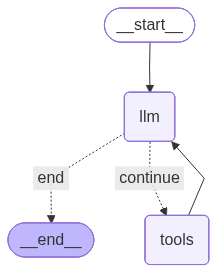

In [26]:
from IPython.display import Image 
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:


# ============================================================================
# FONCTIONS UTILITAIRES
# ============================================================================

def print_stream(stream):
    """Affiche le flux de messages de manière lisible"""
    print("\n" + "="*60)
    for s in stream:
        message = s["messages"][-1]
        if hasattr(message, 'pretty_print'):
            message.pretty_print()
        else:
            print(message)
        print("-"*60)

def run_research(user_query: str):
    """Fonction helper pour lancer une recherche"""
    inputs = {"messages": [("user", user_query)]}
    print_stream(app.stream(inputs, stream_mode="values"))

# ============================================================================
# TESTS
# ============================================================================

if __name__ == "__main__":
    print("\n🎯 SYSTÈME DE RECHERCHE INTELLIGENT ACTIVÉ\n")
    
    # Test 1: Recherche simple
    print("=== TEST 1: Recherche Simple ===")
    run_research("Peux-tu me faire un résumé sur l'impact de l'intelligence artificielle sur le marché du travail?")
    
    # Test 2: Recherche approfondie
    # print("\n\n=== TEST 2: Recherche Approfondie ===")
    # run_research("Fais-moi une analyse complète et détaillée sur les énergies renouvelables")
    
    # # Test 3: Question simple (sans recherche)
    # print("\n\n=== TEST 3: Question Simple ===")
    # run_research("Comment ça va?")

2025-11-17 23:01:24 | INFO     | agent_researcher | Logger initialisé avec succès.
2025-11-17 23:01:24 | INFO     | agent_researcher | Agent researcher initialisé (ID: 354a27ef-c845-457e-9536-2aa1441b81f9)
2025-11-17 23:01:24 | INFO     | search_manager | Logger initialisé avec succès.
2025-11-17 23:01:24 | INFO     | tavily_api | Logger initialisé avec succès.
2025-11-17 23:01:24 | INFO     | search_manager | API Tavily initialisée
2025-11-17 23:01:24 | INFO     | serper_api | Logger initialisé avec succès.
2025-11-17 23:01:24 | INFO     | search_manager | API Serper initialisée
2025-11-17 23:01:24 | INFO     | agent_researcher | APIs disponibles: ['tavily', 'serper']
2025-11-17 23:01:24 | INFO     | llm_service | Logger initialisé avec succès.
2025-11-17 23:01:24 | INFO     | agent_researcher | Service LLM initialisé pour l'extraction de mots-clés
2025-11-17 23:01:24 | INFO     | agent_content_extractor | Logger initialisé avec succès.
2025-11-17 23:01:24 | INFO     | agent_content_e

#  MÉMOIRE & STOCKAGE 💾